In [1]:
import subprocess
import os

# Compile the C code
print("Compiling echo_offline_debug.c...")
result = subprocess.run(
    'gcc -o echo_offline_debug echo_offline_debug.c echo/echo_torbeamNN_x.c echo/echo_torbeamNN_o.c k2c/*.c -lm',
    shell=True,
    capture_output=True,
    text=True
)

if result.returncode == 0:
    print("✓ Compilation successful!")
else:
    print(f"✗ Compilation failed:\n{result.stderr}")
    raise RuntimeError("Failed to compile C code")

Compiling echo_offline_debug.c...
✓ Compilation successful!


# ECHO Multi-Cycle Results Analysis

Visualize ECH optimization results across multiple PCS cycles

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Define Functions

In [15]:
def run_echo(filename, nPop=100, generations=10, mutation_rate=0.2, elite_prop=0.3, inertia=0.3, n_cycles=10, angmin=100., angmax=128., angstep=0.5, dc_min=0.0, dc_max=1.0, bt_scale=1.0, mode=0):
    # ECHO Offline Optimization Parameters
    # Customize these values to run different optimization scenarios

    profile_file = 'ech_targets/'+filename  # Target profile file (101 float values, one per line)

    result = subprocess.run(
        ['./echo_offline_debug', str(nPop), str(generations), str(mutation_rate), 
        str(elite_prop), str(inertia), str(n_cycles), profile_file, str(angmin),
        str(angmax), str(angstep), str(dc_min), str(dc_max), str(bt_scale), str(mode)],
        capture_output=True,
        text=True
    )

    if result.returncode != 0:
        print(f"✗ Execution failed with code {result.returncode}")
        print(f"stderr: {result.stderr}")
        print(f"stdout: {result.stdout}")
        raise RuntimeError("C program execution failed")

    print("✓ Execution completed successfully!")

def plot_opt():
    # Plot the final PCS cycle
    data_all = pd.read_csv('csv_files/profile_output_all_cycles.csv')
    cycles = sorted(data_all['cycle'].unique())
    n_cycles = len(cycles)

    # Get the final cycle
    final_cycle = cycles[-1]
    cycle_data = data_all[data_all['cycle'] == final_cycle]

    # Read gyrotron parameters (angles and duty cycles)
    gyro_params = pd.read_csv('csv_files/gyro_parameters.csv')

    # Create single plot
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))

    # Plot target vs achieved
    ax.plot(cycle_data['rho'], cycle_data['target'], 'r-', linewidth=2.5, label='Target', alpha=0.8)
    ax.plot(cycle_data['rho'], cycle_data['achieved'], 'b--', linewidth=2, label='Achieved', alpha=0.8)

    # Calculate fitness for this cycle
    error = cycle_data['target'].values - cycle_data['achieved'].values
    fitness = np.sum(error**2)

    ax.set_xlabel('Normalized Radius (ρ)', fontsize=12)
    ax.set_ylabel('Power Density (MW/m³)', fontsize=12)
    ax.set_title(f'Final Cycle {final_cycle} (Fitness: {fitness:.6f})', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Displaying final cycle: {final_cycle} of {n_cycles} total cycles")
    print(f"Final fitness: {fitness:.6f}")

    print(gyro_params)

def write_txt_file(filename, profile_target):
    # Write to file
    with open('./ech_targets/'+filename, 'w') as f:
        for value in profile_target:
            f.write(f'{value:.8f}\n')

    with open('./ech_targets/pcs/'+filename,'w') as f:
        f.write('COL_NAMES=|MW/m^3\n')
        f.write('ROW_NAMES=')
        for i in range(len(profile_target)):
            f.write('|row %s' % (i))
        f.write('\n')

        for i in range(len(profile_target)):
            f.write('\t%.8f\n' % (np.round(profile_target[i],8)))

### Generate targets

In [69]:
def gaussian(rho, center, peak, std_dev):
    return peak * np.exp(-0.5 * ((rho - center) / std_dev)**2)

# Generate 101 points for normalized radius
rho = np.linspace(0, 1, 101)

def get_target(target_num):
    if target_num == 1:
        return gaussian(rho, 0.4, 0.5, 0.1)
    
    elif target_num == 2:
        return gaussian(rho, 0.3, 1.4, 0.05)
    
    elif target_num == 3:
        return gaussian(rho, 0.5, 0.3, 0.15)
    
    elif target_num == 4:
        profile_target = np.zeros(101)
        centers = 0.05+np.array([0.2, 0.25, 0.3, 0.35, 0.4])
        peaks = 0.8*np.array([0.5, 0.6, 0.55, 0.45, 0.4])
        stds = 5*[0.02]
        for i in range(5):
            profile_target += gaussian(rho, centers[i], peaks[i], stds[i])
        return profile_target
    
    elif target_num == 5:
        profile_target = np.zeros(101)
        centers = np.array([0.3, 0.325, 0.35, 0.375, 0.4])
        peaks = 0.8*np.array([0.5, 0.6, 0.55, 0.45, 0.4])
        stds = 5*[0.02]
        for i in range(5):
            profile_target += gaussian(rho, centers[i], peaks[i], stds[i])
        return profile_target
    
    elif target_num == 6:
        profile_target = np.zeros(101)
        centers = np.linspace(0.25, 0.6, 5)
        peaks = np.array([0.5, 0.25, 0.25, 0.25, 0.2])
        stds = 5*[0.02]
        for i in range(5):
            profile_target += gaussian(rho, centers[i], peaks[i], stds[i])
        return profile_target
    
    elif target_num == 7:    
        return gaussian(rho, 0.4, 0.75, 0.075)
    
    elif target_num == 8:
        return gaussian(rho, 0.25, 1.4, 0.1)
    
    elif target_num == 9:
        profile_target = np.zeros(101)
        centers = [0.325, 0.475]
        peaks = np.array([0.5, 0.5])
        stds = 2*[0.05]
        for i in range(2):
            profile_target += gaussian(rho, centers[i], peaks[i], stds[i])
        return profile_target
    
    elif target_num == 10:
        return gaussian(rho, 0.15, 1.2, 0.1)
    
    elif target_num == 11:
        return gaussian(rho, 0.2, 1.8, 0.075)
    
    elif target_num == 12:
        return gaussian(rho, 0.45, 0.4, 0.125)
    
    elif target_num == 13:
        return gaussian(rho, 0.35, 0.15, 0.05)
    
    elif target_num == 14:
        return gaussian(rho, 0.25, 0.6, 0.02)

    elif target_num == 15:
        return gaussian(rho, 0.5, 0.08, 0.1)
    
    elif target_num == 16:
        profile_target = np.zeros(101)
        centers = [0.25, 0.45]
        peaks = np.array([0.5, 0.5])
        stds = 2*[0.05]
        for i in range(2):
            profile_target += gaussian(rho, centers[i], peaks[i], stds[i])
        return profile_target
    
    elif target_num == 17:
        profile_target = np.zeros(101)
        profile_target[20:41] = 0.8
        return profile_target
    
    elif target_num == 18:
        profile_target = np.zeros(101)
        y = np.arange(60)[::-1] / 60
        profile_target[20:80] = 0.8 * y
        return profile_target
    
    elif target_num == 19:
        profile_target = np.zeros(101)
        profile_target[20:61] = 0.3
        return profile_target

### Run ECHO

✓ Execution completed successfully!


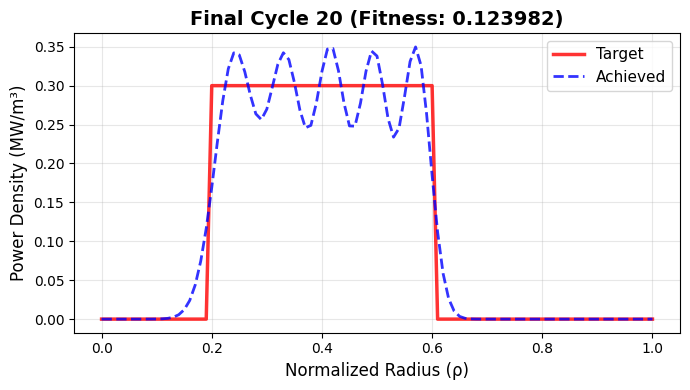

Displaying final cycle: 20 of 20 total cycles
Final fitness: 0.123982
  Gyrotron  Angle  DutyCycle PowerSupply
0       G4  105.0      0.936         PS2
1       G5  109.0      0.690         PS3
2       G8  113.5      0.690         PS3
3       G9  118.0      0.707         PS5
4      G11  131.0      0.666         PS4


In [70]:
ind = 19
filename = f'ech_target_{ind}.txt'
profile_target = get_target(ind)

write_txt_file(filename, profile_target)

dc_min = 0.0
dc_max = 1.0
bt_scale = 1.0
mode = 0 # 0=X-Mode, 1=O-Mode

if 4 <= ind <= 6:
    dc_min = 0.5
    dc_max = 0.5

if 7 <= ind <= 9:
    bt_scale = 0.95

if 10 <= ind <= 12:
    bt_scale = 1.05

if 13 <= ind <= 15:
    mode = 1  # O-Mode

run_echo(filename, 
         nPop=200, 
         generations=50, 
         mutation_rate=0.2, 
         elite_prop=0.3, 
         inertia=0.3, 
         n_cycles=20, 
         angmin=100., 
         angmax=132., 
         angstep=0.5,
         dc_min=dc_min,
         dc_max=dc_max,
         bt_scale=bt_scale,
         mode=mode)
plot_opt()

### Search optimizer parameters

In [367]:
mutation_rate_range = np.linspace(0.05, 0.6, 12)
elite_prop_range = np.linspace(0.3, 0.7, 9)
inertia_range = np.linspace(0.05, 0.3, 6)

best_fitness = 100
fitnesses = []
best_params = (0, 0, 0)
for mutation_rate in tqdm(mutation_rate_range):
    for elite_prop in elite_prop_range:
        for inertia in inertia_range:
            result = subprocess.run(
                ['./echo_offline_debug', str(nPop), str(generations), str(mutation_rate), str(elite_prop), str(inertia), str(n_cycles)],
                capture_output=True,
                text=True
            )
            data_all = pd.read_csv('csv_files/profile_output_all_cycles.csv')
            cycles = sorted(data_all['cycle'].unique())

            fitness_per_cycle = []
            for cycle in cycles:
                cycle_data = data_all[data_all['cycle'] == cycle]
                error = cycle_data['target'].values - cycle_data['achieved'].values
                fitness = np.sum(error**2)
                fitness_per_cycle.append(fitness)

            fitnesses.append((mutation_rate, elite_prop, inertia, fitness_per_cycle[-1]))

            if fitness_per_cycle[-1] < best_fitness:
                best_fitness = fitness_per_cycle[-1]
                best_params = (mutation_rate, elite_prop, inertia)

100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


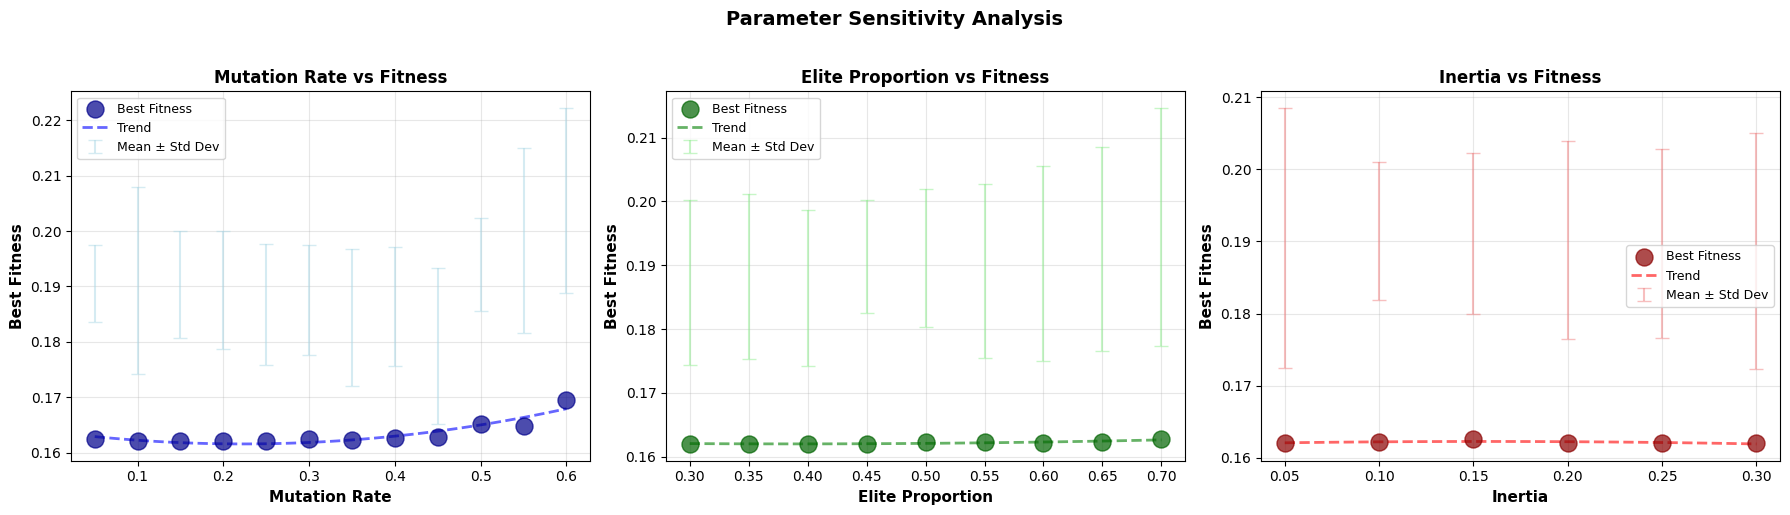

Mutation Rate - Optimal: 0.10
Elite Proportion - Optimal: 0.30
Inertia - Optimal: 0.20


In [110]:
df_results = pd.DataFrame(fitnesses, columns=['mutation_rate', 'elite_prop', 'inertia', 'fitness'])

# Combined Parameter Analysis - All Three Parameters in One Figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Mutation Rate vs Fitness ---
# Group by mutation rate and find minimum fitness for each
mutation_best = df_results.groupby('mutation_rate')['fitness'].agg(['min', 'mean', 'std']).reset_index()

ax = axes[0]
ax.scatter(mutation_best['mutation_rate'], mutation_best['min'], s=150, color='darkblue', 
           label='Best Fitness', zorder=3, alpha=0.7)
ax.errorbar(mutation_best['mutation_rate'], mutation_best['mean'], yerr=mutation_best['std'],
            fmt='none', ecolor='lightblue', alpha=0.5, capsize=5, label='Mean ± Std Dev')

# Add trend line
z = np.polyfit(mutation_best['mutation_rate'], mutation_best['min'], 2)
p = np.poly1d(z)
x_smooth = np.linspace(mutation_best['mutation_rate'].min(), mutation_best['mutation_rate'].max(), 100)
ax.plot(x_smooth, p(x_smooth), 'b--', linewidth=2, alpha=0.6, label='Trend')

ax.set_xlabel('Mutation Rate', fontsize=11, fontweight='bold')
ax.set_ylabel('Best Fitness', fontsize=11, fontweight='bold')
ax.set_title('Mutation Rate vs Fitness', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# --- Plot 2: Elite Proportion vs Fitness ---
elite_best = df_results.groupby('elite_prop')['fitness'].agg(['min', 'mean', 'std']).reset_index()

ax = axes[1]
ax.scatter(elite_best['elite_prop'], elite_best['min'], s=150, color='darkgreen', 
           label='Best Fitness', zorder=3, alpha=0.7)
ax.errorbar(elite_best['elite_prop'], elite_best['mean'], yerr=elite_best['std'],
            fmt='none', ecolor='lightgreen', alpha=0.5, capsize=5, label='Mean ± Std Dev')

# Add trend line
z = np.polyfit(elite_best['elite_prop'], elite_best['min'], 2)
p = np.poly1d(z)
x_smooth = np.linspace(elite_best['elite_prop'].min(), elite_best['elite_prop'].max(), 100)
ax.plot(x_smooth, p(x_smooth), 'g--', linewidth=2, alpha=0.6, label='Trend')

ax.set_xlabel('Elite Proportion', fontsize=11, fontweight='bold')
ax.set_ylabel('Best Fitness', fontsize=11, fontweight='bold')
ax.set_title('Elite Proportion vs Fitness', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# --- Plot 3: Inertia vs Fitness ---
inertia_best = df_results.groupby('inertia')['fitness'].agg(['min', 'mean', 'std']).reset_index()

ax = axes[2]
ax.scatter(inertia_best['inertia'], inertia_best['min'], s=150, color='darkred', 
           label='Best Fitness', zorder=3, alpha=0.7)
ax.errorbar(inertia_best['inertia'], inertia_best['mean'], yerr=inertia_best['std'],
            fmt='none', ecolor='lightcoral', alpha=0.5, capsize=5, label='Mean ± Std Dev')

# Add trend line
z = np.polyfit(inertia_best['inertia'], inertia_best['min'], 2)
p = np.poly1d(z)
x_smooth = np.linspace(inertia_best['inertia'].min(), inertia_best['inertia'].max(), 100)
ax.plot(x_smooth, p(x_smooth), 'r--', linewidth=2, alpha=0.6, label='Trend')

ax.set_xlabel('Inertia', fontsize=11, fontweight='bold')
ax.set_ylabel('Best Fitness', fontsize=11, fontweight='bold')
ax.set_title('Inertia vs Fitness', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

plt.suptitle('Parameter Sensitivity Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('plots/param_sensitivity_combined.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Mutation Rate - Optimal: {mutation_best.loc[mutation_best['min'].idxmin(), 'mutation_rate']:.2f}")
print(f"Elite Proportion - Optimal: {elite_best.loc[elite_best['min'].idxmin(), 'elite_prop']:.2f}")
print(f"Inertia - Optimal: {inertia_best.loc[inertia_best['min'].idxmin(), 'inertia']:.2f}")

# Plotting

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [103]:
# Read multi-cycle data
data_all = pd.read_csv('csv_files/profile_output_all_cycles.csv')
print(f"Total data shape: {data_all.shape}")
print(f"Number of cycles: {data_all['cycle'].nunique()}")
print(f"Columns: {data_all.columns.tolist()}")
data_all.head()

Total data shape: (505, 9)
Number of cycles: 5
Columns: ['cycle', 'rho', 'target', 'achieved', 'gyro4', 'gyro5', 'gyro8', 'gyro9', 'gyro11']


,cycle,rho,target,achieved,gyro4,gyro5,gyro8,gyro9,gyro11
0,1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Profiles of cycle

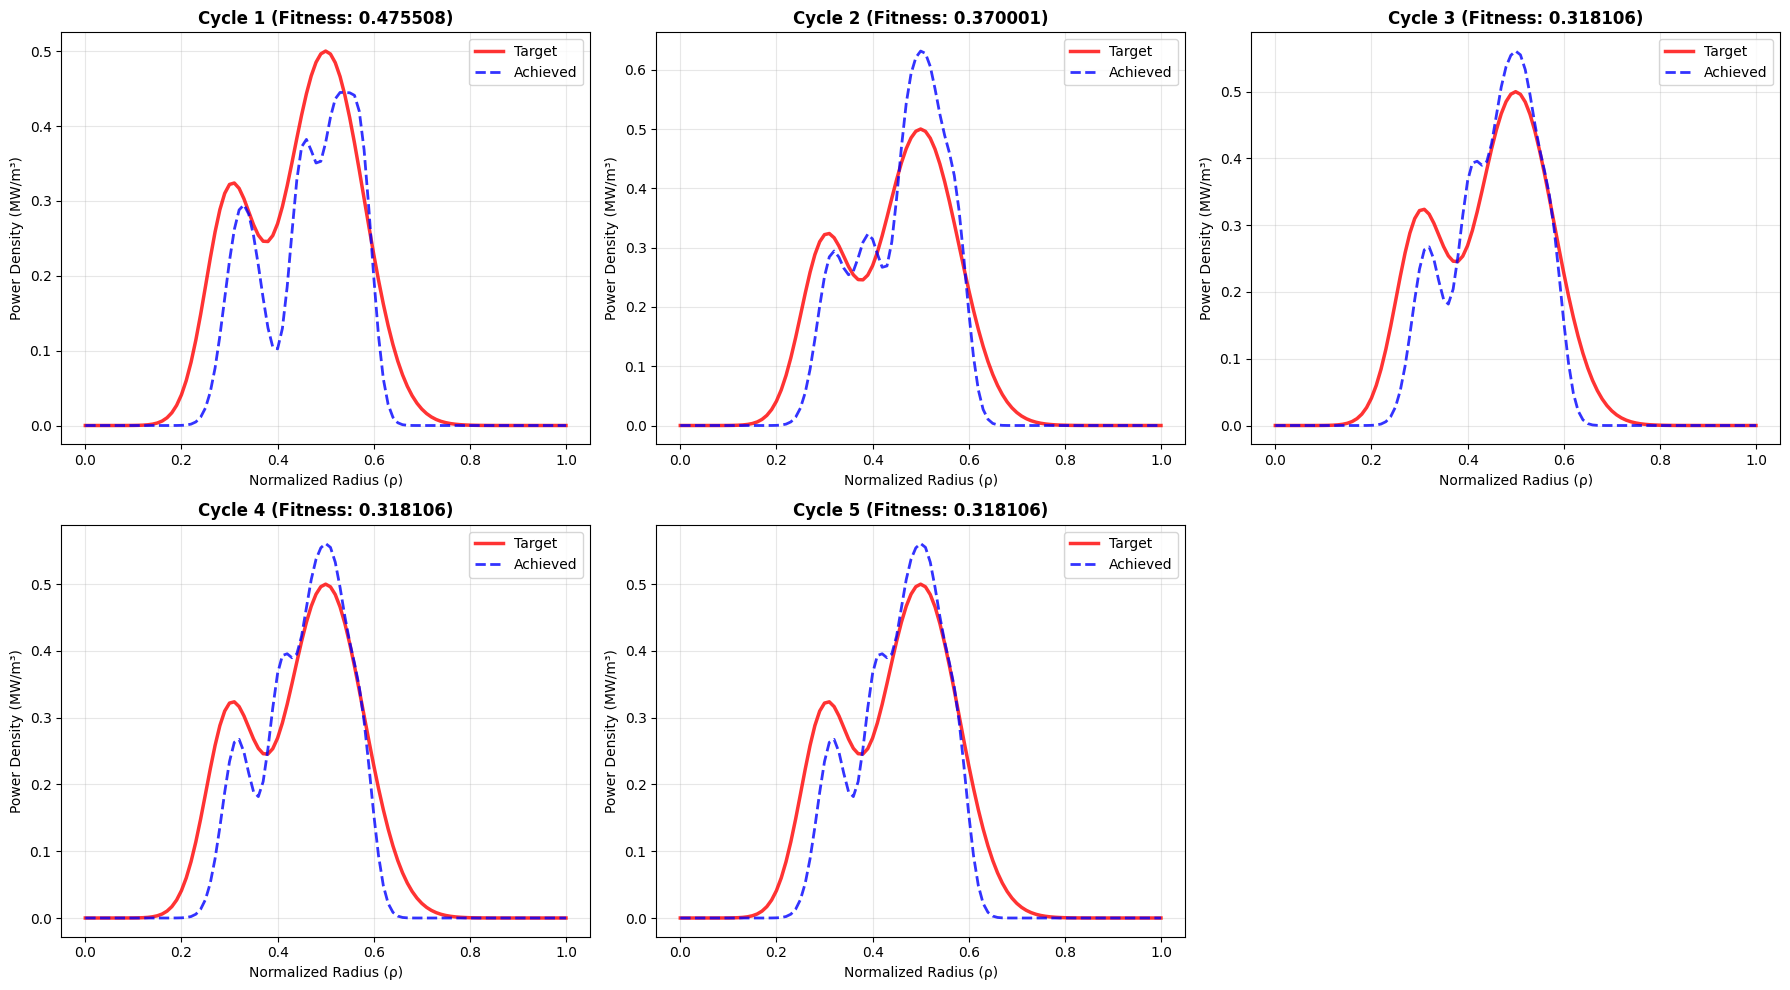

In [104]:
# Plot profiles for each PCS cycle
cycles = sorted(data_all['cycle'].unique())
n_cycles = len(cycles)

# Create subplots grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, cycle in enumerate(cycles):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    cycle_data = data_all[data_all['cycle'] == cycle]
    
    # Plot target vs achieved
    ax.plot(cycle_data['rho'], cycle_data['target'], 'r-', linewidth=2.5, label='Target', alpha=0.8)
    ax.plot(cycle_data['rho'], cycle_data['achieved'], 'b--', linewidth=2, label='Achieved', alpha=0.8)
    
    # Calculate fitness for this cycle
    error = cycle_data['target'].values - cycle_data['achieved'].values
    fitness = np.sum(error**2)
    
    ax.set_xlabel('Normalized Radius (ρ)')
    ax.set_ylabel('Power Density (MW/m³)')
    ax.set_title(f'Cycle {cycle} (Fitness: {fitness:.6f})', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_cycles, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('plots/echo_cycles_overview.png', dpi=150, bbox_inches='tight')
plt.show()

### Fitness across cycles

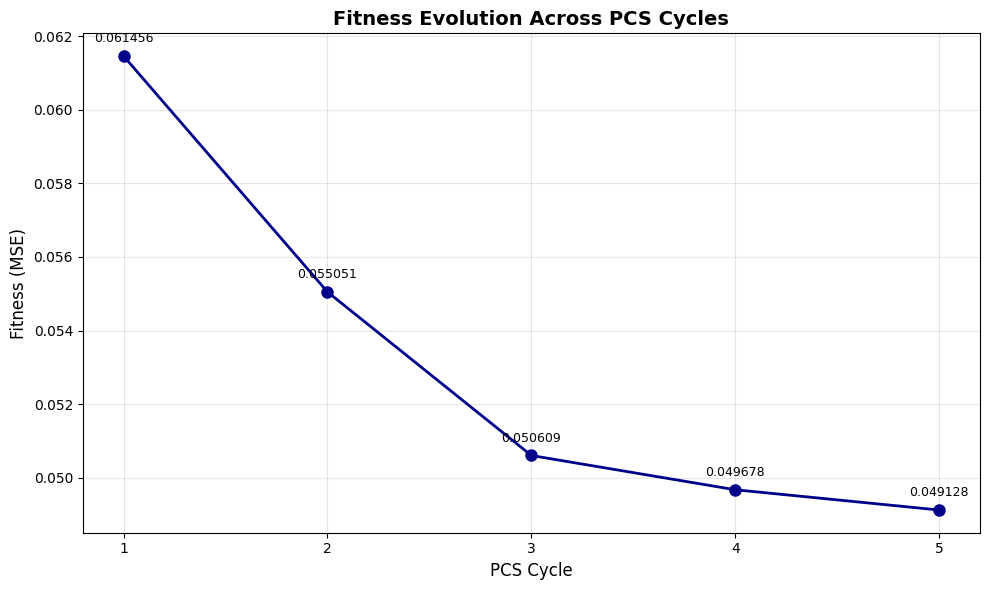

Initial Fitness (Cycle 1): 0.061456
Final Fitness (Cycle 5): 0.049128
Improvement: 20.1%


In [33]:
# Plot fitness evolution across cycles
fitness_per_cycle = []
for cycle in cycles:
    cycle_data = data_all[data_all['cycle'] == cycle]
    error = cycle_data['target'].values - cycle_data['achieved'].values
    fitness = np.sum(error**2)
    fitness_per_cycle.append(fitness)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(cycles, fitness_per_cycle, 'o-', linewidth=2, markersize=8, color='darkblue')
ax.set_xlabel('PCS Cycle', fontsize=12)
ax.set_ylabel('Fitness (MSE)', fontsize=12)
ax.set_title('Fitness Evolution Across PCS Cycles', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks(cycles)

# Annotate each point
for i, (c, f) in enumerate(zip(cycles, fitness_per_cycle)):
    ax.annotate(f'{f:.6f}', (c, f), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('plots/echo_fitness_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Initial Fitness (Cycle 1): {fitness_per_cycle[0]:.6f}")
print(f"Final Fitness (Cycle {len(cycles)}): {fitness_per_cycle[-1]:.6f}")
print(f"Improvement: {(fitness_per_cycle[0] - fitness_per_cycle[-1])/fitness_per_cycle[0]*100:.1f}%")

### Cycle Plots

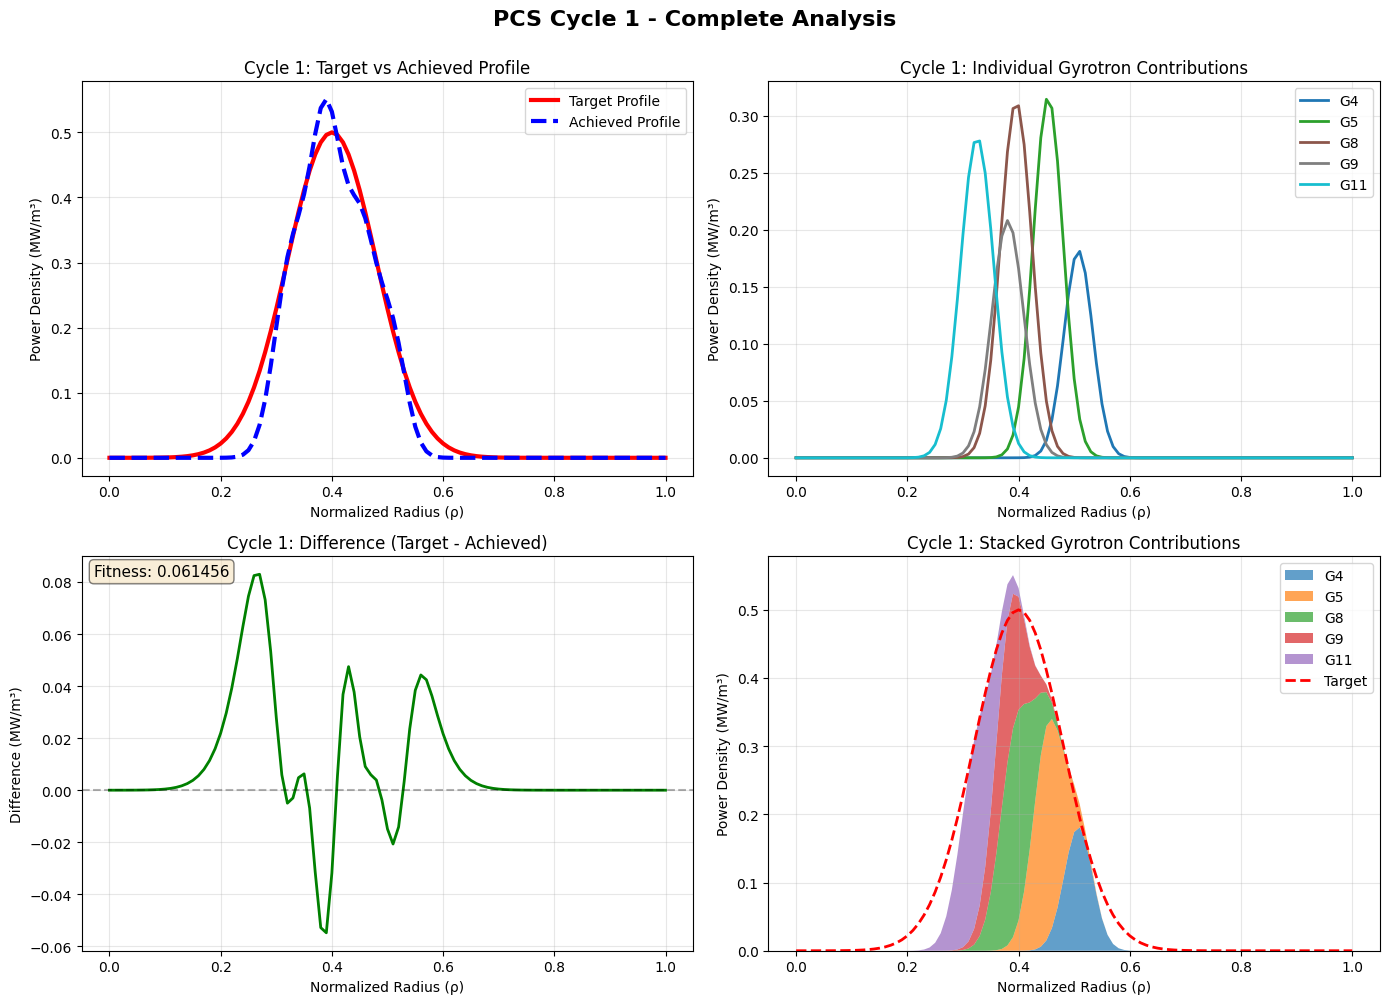

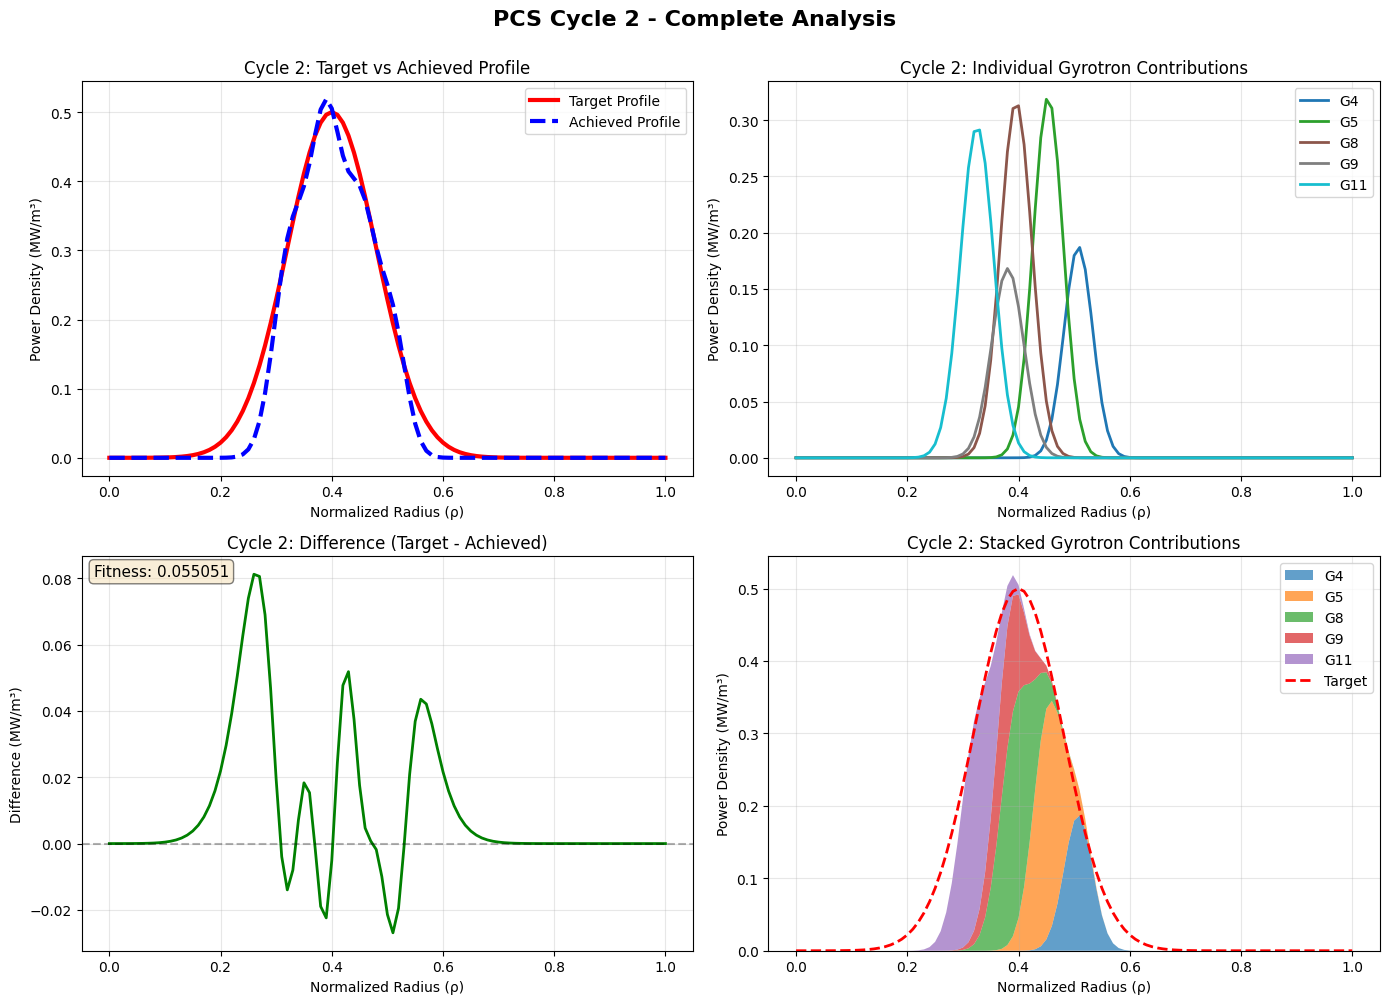

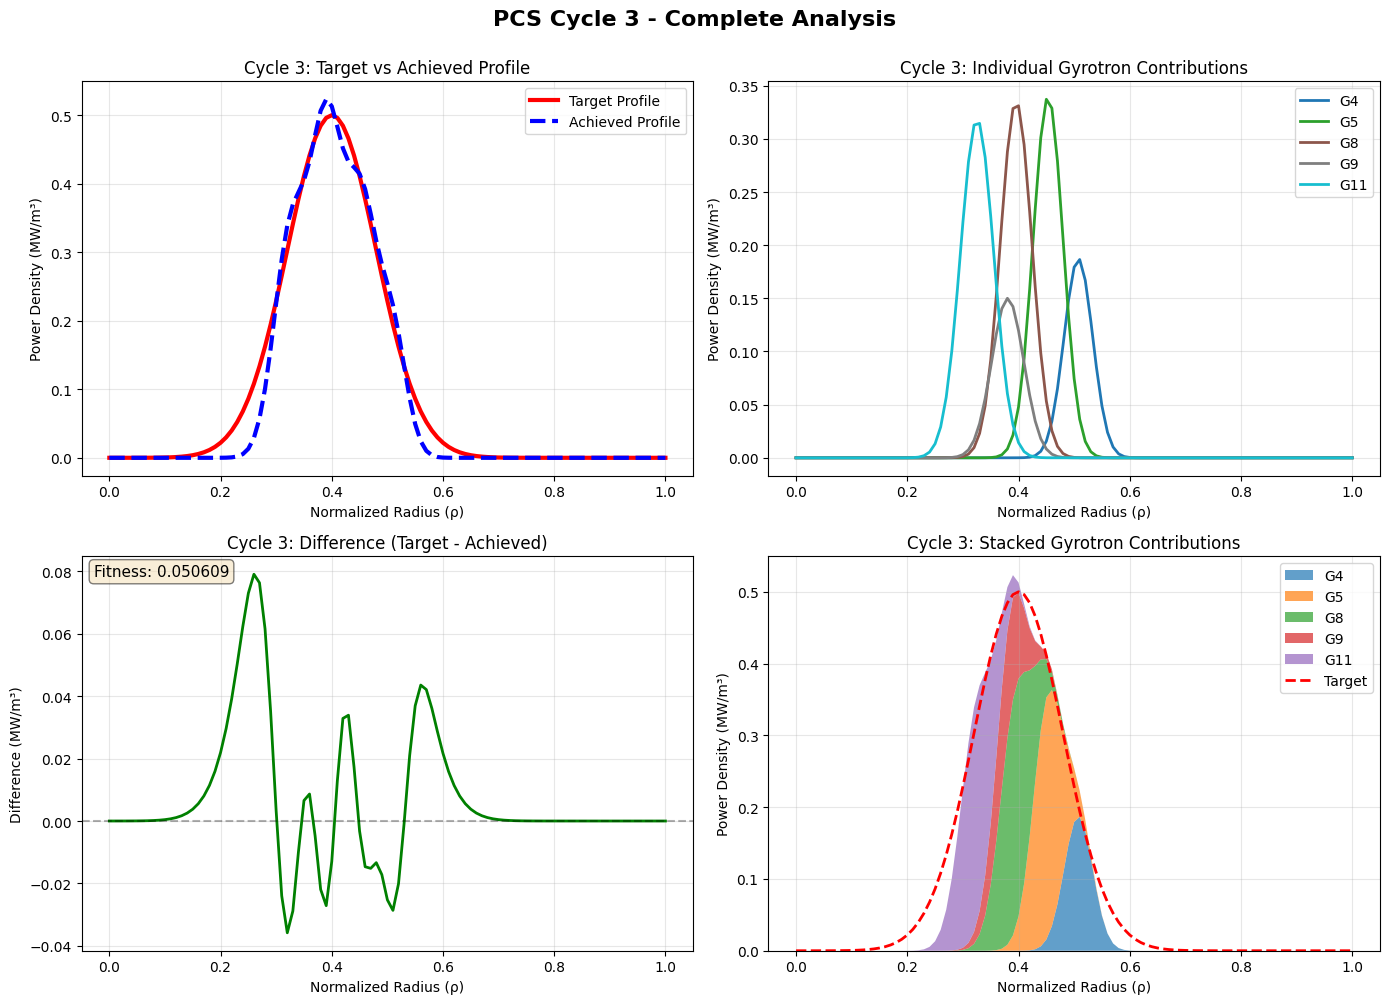

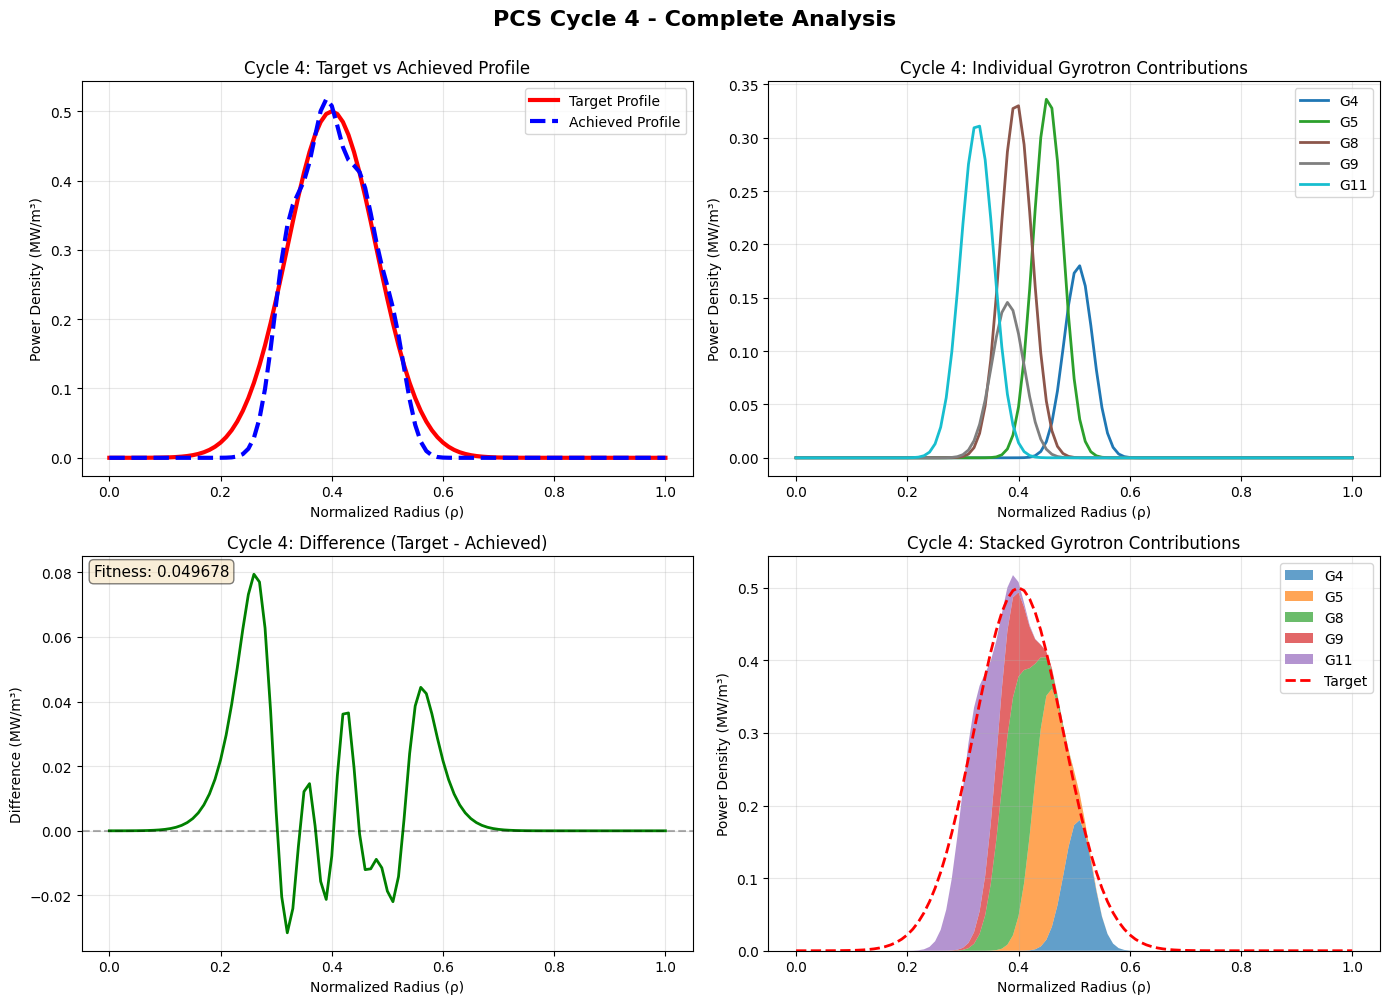

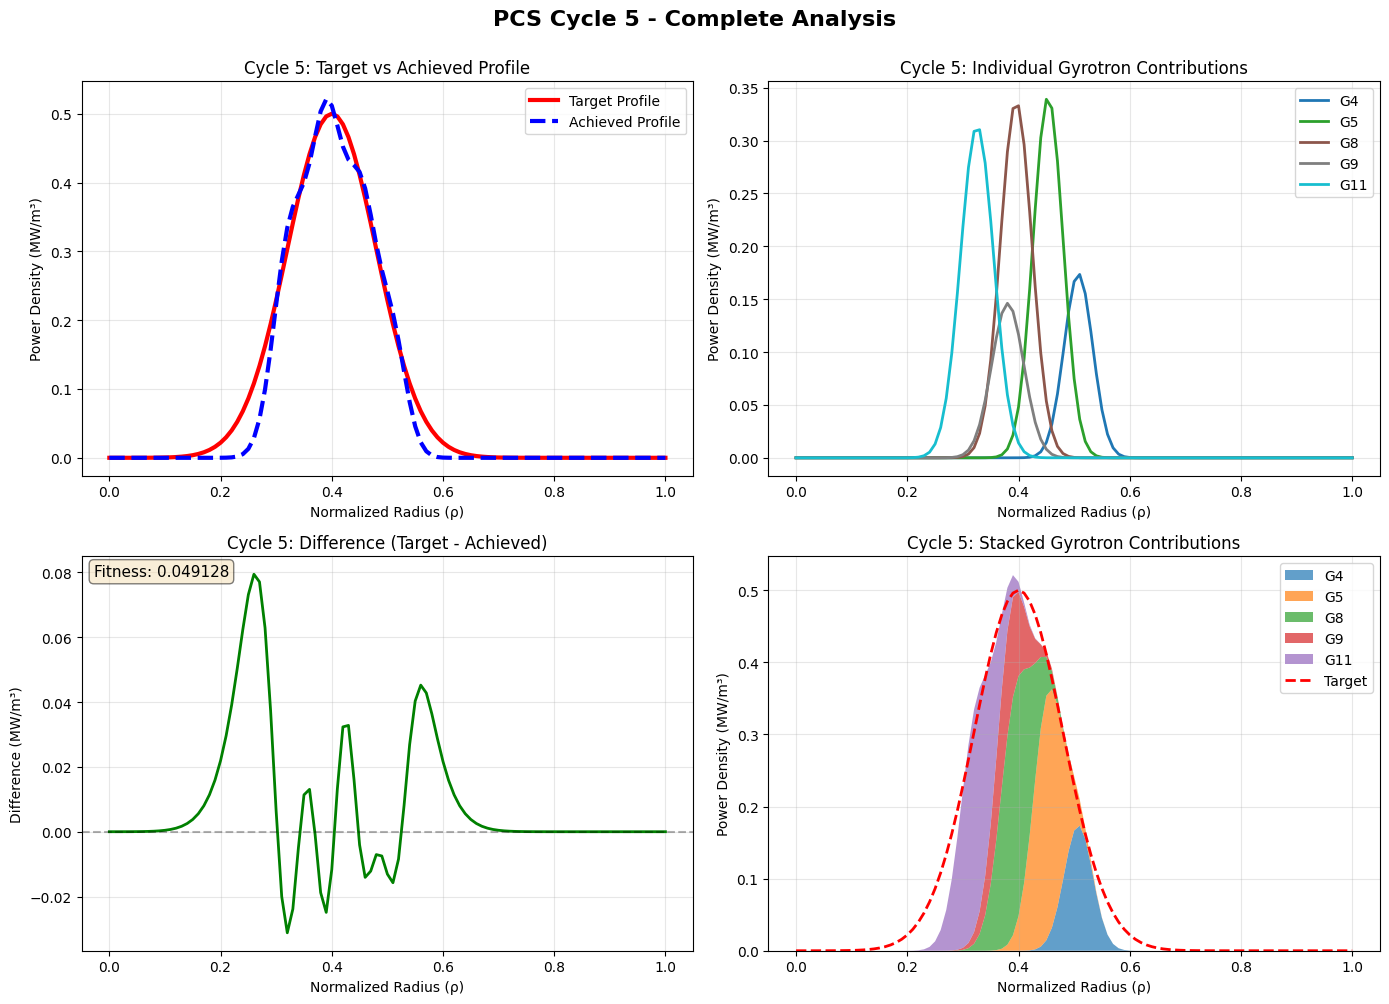

In [34]:
# Create detailed 2x2 subplot for each cycle
for cycle in cycles:
    cycle_data = data_all[data_all['cycle'] == cycle].copy()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Target vs Achieved
    ax = axes[0, 0]
    ax.plot(cycle_data['rho'], cycle_data['target'], 'r-', linewidth=3, label='Target Profile')
    ax.plot(cycle_data['rho'], cycle_data['achieved'], 'b--', linewidth=3, label='Achieved Profile')
    ax.set_xlabel('Normalized Radius (ρ)')
    ax.set_ylabel('Power Density (MW/m³)')
    ax.set_title(f'Cycle {cycle}: Target vs Achieved Profile')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Individual Gyrotron Contributions
    ax = axes[0, 1]
    gyro_cols = [col for col in cycle_data.columns if col.startswith('gyro')]
    colors = plt.cm.tab10(np.linspace(0, 1, len(gyro_cols)))
    gyro_labels = [col.replace('gyro', 'G').upper() for col in gyro_cols]
    for i, (col, label) in enumerate(zip(gyro_cols, gyro_labels)):
        ax.plot(cycle_data['rho'], cycle_data[col], linewidth=2, label=label, color=colors[i])
    ax.set_xlabel('Normalized Radius (ρ)')
    ax.set_ylabel('Power Density (MW/m³)')
    ax.set_title(f'Cycle {cycle}: Individual Gyrotron Contributions')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Difference (Error)
    ax = axes[1, 0]
    difference = cycle_data['target'] - cycle_data['achieved']
    ax.plot(cycle_data['rho'], difference, 'g-', linewidth=2)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.set_xlabel('Normalized Radius (ρ)')
    ax.set_ylabel('Difference (MW/m³)')
    ax.set_title(f'Cycle {cycle}: Difference (Target - Achieved)')
    ax.grid(True, alpha=0.3)
    
    # Calculate and display fitness
    fitness = np.sum(difference**2)
    ax.text(0.02, 0.98, f'Fitness: {fitness:.6f}', 
            transform=ax.transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 4: Stacked contributions
    ax = axes[1, 1]
    gyro_data = [cycle_data[col].values for col in gyro_cols]
    ax.stackplot(cycle_data['rho'], *gyro_data, labels=gyro_labels, alpha=0.7)
    ax.plot(cycle_data['rho'], cycle_data['target'], 'r--', linewidth=2, label='Target')
    ax.set_xlabel('Normalized Radius (ρ)')
    ax.set_ylabel('Power Density (MW/m³)')
    ax.set_title(f'Cycle {cycle}: Stacked Gyrotron Contributions')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'PCS Cycle {cycle} - Complete Analysis', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(f'plots/echo_cycle_{cycle}_detailed.png', dpi=150, bbox_inches='tight')
    plt.show()

## Manual plotting

Script to manually add angles, targets and powers to see what the total looks like, and calculate fitness.

/var/folders/gj/fx72q8gd497636f9415pl1wh0000gn/T/ipykernel_73396/2084695935.py:111: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(rho, target_profile, 'r-', linewidth=2.5, label='Target', linestyle='--')


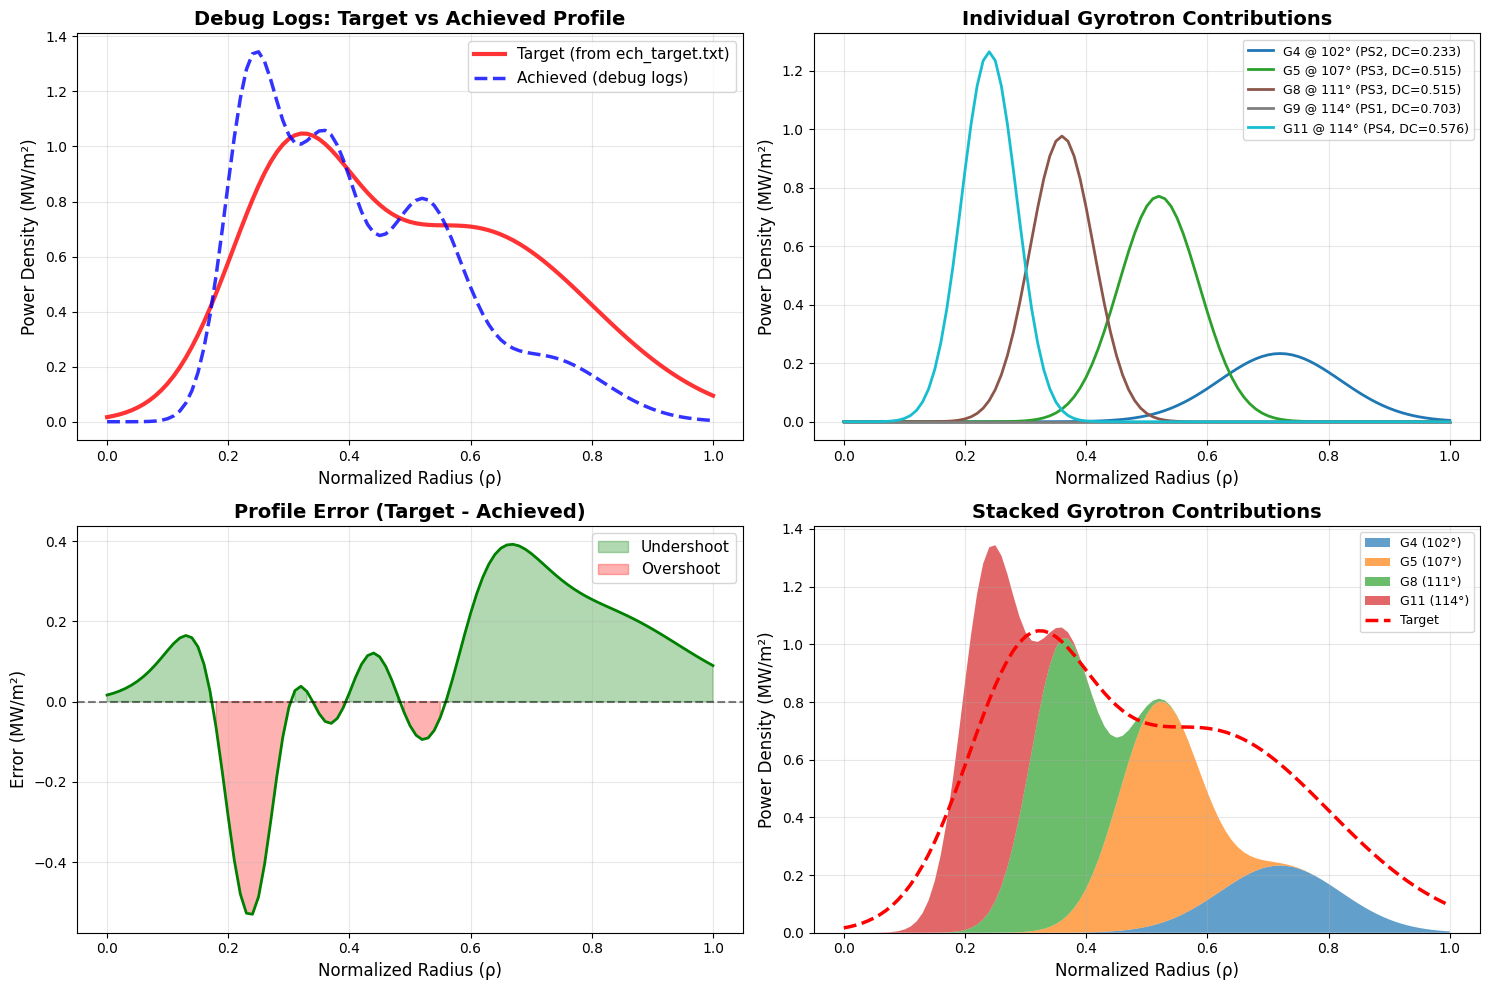


LATEST RUN PERFORMANCE ANALYSIS

Fitness (MSE):        4.850167
Max Absolute Error:   0.529778 MW/m²
RMS Error:            2.202310 MW/m²

Total Target Power:   54.328
Total Achieved Power: 45.978
Power Balance Error:  -15.37%

Peak Target:          1.047 MW/m² at ρ=0.32
Peak Achieved:        1.344 MW/m² at ρ=0.25

OPTIMIZED GYROTRON CONFIGURATION:
G4: 102.0° (PS2, DC=0.233, P=0.5 MW)
G5: 107.0° (PS3, DC=0.515, P=0.5 MW)
G8: 111.0° (PS3, DC=0.515, P=0.5 MW)
G11: 114.0° (PS4, DC=0.576, P=0.5 MW)



In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# Target profile from ech_target.txt
target_profile = np.array([
    0.01666300, 0.02096000, 0.02631700, 0.03295600, 0.04112700, 0.05110500, 0.06319300, 0.07770600, 0.09497100, 0.11530800,
    0.13902400, 0.16638700, 0.19761300, 0.23284600, 0.27213400, 0.31541400, 0.36249400, 0.41304200, 0.46657700, 0.52247200,
    0.57995900, 0.63814900, 0.69605100, 0.75261200, 0.80674500, 0.85738300, 0.90351500, 0.94423600, 0.97878500, 1.00658300,
    1.02725700, 1.04066000, 1.04687700, 1.04621300, 1.03918300, 1.02648100, 1.00894300, 0.98750800, 0.96317100, 0.93694200,
    0.90979600, 0.88264200, 0.85628600, 0.83140900, 0.80855300, 0.78811000, 0.77032300, 0.75529700, 0.74300800, 0.73332200,
    0.72601600, 0.72079500, 0.71731900, 0.71521600, 0.71410600, 0.71361300, 0.71337700, 0.71306600, 0.71238200, 0.71106200,
    0.70888700, 0.70567700, 0.70129000, 0.69562300, 0.68861000, 0.68021300, 0.67042500, 0.65926300, 0.64676700, 0.63299300,
    0.61801600, 0.60192200, 0.58480700, 0.56677700, 0.54794300, 0.52842000, 0.50832500, 0.48777600, 0.46689200, 0.44578700,
    0.42457400, 0.40336200, 0.38225300, 0.36134500, 0.34072700, 0.32048400, 0.30069000, 0.28141500, 0.26271800, 0.24465000,
    0.22725700, 0.21057300, 0.19462600, 0.17943800, 0.16502200, 0.15138600, 0.13852900, 0.12644800, 0.11513200, 0.10456700,
    0.09473500
])

# Debug log data from echo_master.h
# Angles: G4=100, G5=108, G8=110, G9=114, G11=119
# Duty cycles: PS1=0.703, PS2=0.233, PS3=0.515, PS4=0.576, PS5=0.414
# Power: 0.5 MW per gyrotron

# Gyrotron configuration (G-index: angle, power_supply, duty_cycle, power)
gyro_config = {
    'G4': {'angle': 102.0, 'ps': 1, 'power': 0.5},
    'G5': {'angle': 107.0, 'ps': 2, 'power': 0.5},
    'G8': {'angle': 111.0, 'ps': 2, 'power': 0.5},
    'G9': {'angle': 114.0, 'ps': 0,  'power': 0},
    'G11': {'angle': 114.0, 'ps': 3,'power': 0.5},
}

# Duty cycles per power supply
ps_duty = [0.703, 0.233, 0.515, 0.576, 0.414]

def gaussian_profile(angle, npoints=101):
    """Calculate Gaussian deposition profile for a given angle"""
    center = 0.8 + 0.04 * (100.0 - angle)
    std = 1.0 / (angle - 92.0)
    
    # Normalize by area (same as echo code)
    M_SQRT1_2 = 0.7071067811865475
    area = 1.2533 * std * (erf(center / std * M_SQRT1_2) - erf((center - 1.0) / std * M_SQRT1_2))
    
    rho = np.linspace(0, 1, npoints)
    profile = 0.5 / area * np.exp(-0.5 * ((rho - center) / std)**2)
    
    return profile

# Calculate individual gyrotron profiles
rho = np.linspace(0, 1, 101)
gyro_profiles = {}
achieved_profile = np.zeros(101)

for name, config in gyro_config.items():
    # Get Gaussian profile for this angle
    profile = gaussian_profile(config['angle'])
    
    # Scale by power * duty cycle
    scale = config['power'] * ps_duty[config['ps']]
    scaled_profile = profile * scale
    
    gyro_profiles[name] = scaled_profile
    achieved_profile += scaled_profile

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Target vs Achieved
ax = axes[0, 0]
ax.plot(rho, target_profile, 'r-', linewidth=3, label='Target (from ech_target.txt)', alpha=0.8)
ax.plot(rho, achieved_profile, 'b--', linewidth=2.5, label='Achieved (debug logs)', alpha=0.8)
ax.set_xlabel('Normalized Radius (ρ)', fontsize=12)
ax.set_ylabel('Power Density (MW/m²)', fontsize=12)
ax.set_title('Debug Logs: Target vs Achieved Profile', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 2: Individual Gyrotron Contributions
ax = axes[0, 1]
colors = plt.cm.tab10(np.linspace(0, 1, len(gyro_profiles)))
for i, (name, profile) in enumerate(gyro_profiles.items()):
    config = gyro_config[name]
    label = f"{name} @ {config['angle']:.0f}° (PS{config['ps']+1}, DC={ps_duty[config['ps']]:.3f})"
    ax.plot(rho, profile, linewidth=2, label=label, color=colors[i])
ax.set_xlabel('Normalized Radius (ρ)', fontsize=12)
ax.set_ylabel('Power Density (MW/m²)', fontsize=12)
ax.set_title('Individual Gyrotron Contributions', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Error Profile
ax = axes[1, 0]
error = target_profile - achieved_profile
ax.plot(rho, error, 'g-', linewidth=2)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax.fill_between(rho, 0, error, alpha=0.3, color='green', where=(error>=0), label='Undershoot')
ax.fill_between(rho, 0, error, alpha=0.3, color='red', where=(error<0), label='Overshoot')
ax.set_xlabel('Normalized Radius (ρ)', fontsize=12)
ax.set_ylabel('Error (MW/m²)', fontsize=12)
ax.set_title('Profile Error (Target - Achieved)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 4: Stacked Contributions (only active gyros)
ax = axes[1, 1]
profiles_list = [gyro_profiles[name] for name in ['G4', 'G5', 'G8', 'G11'] if gyro_config[name]['power'] > 0]
labels_list = [f"{name} ({gyro_config[name]['angle']:.0f}°)" for name in ['G4', 'G5', 'G8', 'G11'] if gyro_config[name]['power'] > 0]
ax.stackplot(rho, *profiles_list, labels=labels_list, alpha=0.7)
ax.plot(rho, target_profile, 'r-', linewidth=2.5, label='Target', linestyle='--')
ax.set_xlabel('Normalized Radius (ρ)', fontsize=12)
ax.set_ylabel('Power Density (MW/m²)', fontsize=12)
ax.set_title('Stacked Gyrotron Contributions', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
mse = np.sum(error**2)
print(f"\n{'='*60}")
print(f"LATEST RUN PERFORMANCE ANALYSIS")
print(f"{'='*60}")
print(f"\nFitness (MSE):        {mse:.6f}")
print(f"Max Absolute Error:   {np.max(np.abs(error)):.6f} MW/m²")
print(f"RMS Error:            {np.sqrt(mse):.6f} MW/m²")
print(f"\nTotal Target Power:   {np.sum(target_profile):.3f}")
print(f"Total Achieved Power: {np.sum(achieved_profile):.3f}")
print(f"Power Balance Error:  {100 * (np.sum(achieved_profile) - np.sum(target_profile)) / np.sum(target_profile):.2f}%")
print(f"\nPeak Target:          {np.max(target_profile):.3f} MW/m² at ρ={rho[np.argmax(target_profile)]:.2f}")
print(f"Peak Achieved:        {np.max(achieved_profile):.3f} MW/m² at ρ={rho[np.argmax(achieved_profile)]:.2f}")

print(f"\n{'='*60}")
print(f"OPTIMIZED GYROTRON CONFIGURATION:")
print(f"{'='*60}")
for name in ['G4', 'G5', 'G8', 'G11']:
    config = gyro_config[name]
    if config['power'] > 0:
        print(f"{name}: {config['angle']:.1f}° (PS{config['ps']+1}, DC={ps_duty[config['ps']]:.3f}, P={config['power']:.1f} MW)")
    else:
        print(f"{name}: DISABLED")
print(f"{'='*60}\n")
